Predicting the Beats: A Comprehensive EDA & Baseline Model
Welcome to this in-depth analysis of the "Predicting the Beats" dataset. The goal of this competition is to predict the popularity of a song based on its audio features. In this notebook, we will follow a structured data science workflow:
Explore and Understand the Data (EDA): We'll dive deep into the dataset to understand its structure, identify patterns, and uncover insights.
Preprocess and Engineer Features: We'll clean the data and create new features to improve model performance.

Build a Baseline Model: We'll use XGBoost, a powerful gradient boosting algorithm, to establish a performance benchmark.
Evaluate the Model: We will assess the model's performance and identify its strengths and weaknesses.



In [1]:
from IPython.display import display, HTML

img_url = "https://www.kaggle.com/competitions/91720/images/header"

display(HTML(f'''
<div style="text-align: center;">
    <img src="{img_url}" width="800">
</div>
'''))

## Let's begin!

In [2]:
from IPython.display import display, HTML

display(HTML("""
<style>
.toc a {
    text-decoration: none;
    color: #0077cc;
    font-weight: bold;
    padding: 5px;
    display: block;
}
.toc a:hover {
    background: #e0f0ff;
    cursor: pointer;
}
</style>

<div class="toc">
    <h3>Table of Contents</h3>
    <a href="#dataloading">1. Data Loading</a>
    <a href="#eda">2. Exploratory Data Analysis</a>
    <a href="#preprocessing">3. Data Preprocessing</a>
    <a href="#feature-engineering">4. Feature Engineering</a>
    <a href="#modeling">5. Modeling</a>
    <a href="#evaluation">6. Evaluation</a>
    <a href="#conclusion">7. Conclusion</a>
</div>
"""))


<a id="dataloading"></a>
# 1. Data Loading

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [ ]:
test  = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")  

In [ ]:
# Quick look
train.head()

In [ ]:
print("Shape of dataset:", train.shape)

👉 Observation:

The dataset consists of 524,164 observations and 11 features.

The majority of the features are numerical.

<a id="eda"></a>
# 2. Exploratory Data Analysis

In [ ]:

train.info()



In [ ]:
train.describe(include='all').T


In [ ]:
# Missing values
print("Missing Values:", train.isnull().sum())

In [ ]:
#Duplicate rows
print("Duplicate rows:", train.duplicated().sum())

👉 Observation:

The dataset was examined for data quality issues. 
No missing values were detected across all variables, and no duplicate rows were identified.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target = "BeatsPerMinute"

def plot_target_distribution(train, target, bins=50):
    """
    Generates a comprehensive plot for analyzing a regression target variable.
    
    The plot includes a histogram, KDE, boxplot, and key statistical annotations.
    
    Parameters:
    - train (pd.DataFrame): The input dataframe.
    - target (str): The name of the target column.
    - bins (int): The number of bins for the histogram.
    """
    # --- Calculate Statistics ---
    mean_val = train[target].mean()
    
    median_val = train[target].median()
    std_val = train[target].std()
    skew_val = train[target].skew()
    kurt_val = train[target].kurt()

    # --- Create the plot ---
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, 
        gridspec_kw={'height_ratios': (0.8, 0.2)}
    )
    
    # --- Histogram and KDE (Top Plot) ---
    sns.histplot(train[target], ax=ax_hist, kde=True, bins=bins, line_kws={'linewidth': 2})
    
    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax_hist.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    
    ax_hist.set_title(f'Distribution of {target}', fontsize=16, weight='bold')
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.legend(loc='upper right')
    ax_hist.grid(axis='y', linestyle='--', alpha=0.7)
    ax_hist.set_xlabel('')  # Hide x-label for the top plot

    # --- Statistical Annotations ---
    stats_text = (
        f"Std. Dev: {std_val:.2f}\n"
        f"Skewness: {skew_val:.2f}\n"
        f"Kurtosis: {kurt_val:.2f}"
    )
    ax_hist.text(0.97, 0.97, stats_text, transform=ax_hist.transAxes, fontsize=12,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    # --- Boxplot (Bottom Plot) ---
    sns.boxplot(x=train[target], ax=ax_box, color='skyblue')
    ax_box.set_xlabel(target, fontsize=12)
    ax_box.set_ylabel(' ', fontsize=12)

    # --- Final Touches ---
    plt.suptitle(f'Detailed Analysis of Target Variable: {target}', fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()
plot_target_distribution(train, target)


👉 Observation:

The target variable BeatsPerMinute exhibits an approximately normal distribution, with values centered around 120 BPM. This bell-shaped pattern suggests that most observations cluster near the mean, indicating a relatively symmetric distribution with limited skewness.

In [ ]:
# ========================
# 4. Feature Distributions
# ========================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select numeric features (excluding ID if present)
num_features = train.select_dtypes(include=[np.number]).columns.tolist()
# Columns to exclude
exclude_cols = ["id", "BeatsPerMinute"]
num_features = [col for col in num_features if col not in exclude_cols]

# Define grid size automatically (rows & cols)

n_features = len(num_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(num_features):
    sns.histplot(train[col], bins=30, kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution of {col}", fontsize=12, weight="bold")
    axes[i].set_xlabel("")
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

# Remove empty subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions", fontsize=16, weight="bold", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Expert Analysis of Feature Distributions


#### 👉 Observation: RhythmScore

The RhythmScore feature approximates a normal distribution but is slightly left-skewed, with a central tendency around 0.6-0.7. The distribution is also somewhat multimodal (lumpy), suggesting there might be several common types of rhythm patterns. There is also a small spike at the 1.0 mark, which could indicate a hard cap on the score.

#### 👉 Observation: AudioLoudness

This feature displays a clear left-skewed (negatively skewed) normal distribution. The majority of tracks are concentrated in the -15 to -5 dB range, with a long tail of quieter tracks. This is one of the most "bell-shaped" curves here, despite its skew.

#### 👉 Observation: VocalContent

This distribution exhibits a strong right-skew (positive skew). A vast majority of tracks have very low vocal content, with a massive peak near zero, followed by a long tail representing tracks with more prominent vocals. This pattern is characteristic of zero-inflated data.

#### 👉 Observation: AcousticQuality

Similar to VocalContent, this feature is highly right-skewed. Most songs have a very low AcousticQuality score, indicating that purely or highly acoustic tracks are a minority in this dataset compared to electronically produced ones. The underlying data structure appears zero-inflated as well.

#### 👉 Observation: InstrumentalScore

This distribution mirrors that of VocalContent and AcousticQuality, showing a strong positive skew with a peak at zero. This suggests that most songs in the dataset are not purely instrumental. The long tail represents the smaller subset of instrumental tracks.

#### 👉 Observation: LivePerformanceLikelihood

This follows the same pattern of extreme right-skew. The overwhelming majority of tracks have a near-zero likelihood of being a live performance, which is expected as studio recordings are far more common.

#### 👉 Observation: MoodScore

This feature has a fascinating bimodal (or possibly multimodal) distribution, with distinct peaks around 0.3 and 0.7. This strongly indicates the presence of at least two underlying clusters of songs within the data, perhaps corresponding to "low mood" (e.g., sad, calm) and "high mood" (e.g., happy, energetic) tracks. The mean of this feature would be a misleading statistic.

#### 👉 Observation: TrackDurationMs

The track duration shows a distribution that is close to normal but with a slight right skew, which is common for time-based features. The central peak is around 220,000 ms (approx. 3.7 minutes), which is a typical song length. An interesting artifact is the sharp dip in the center of the main peak, which could warrant further investigation.

#### 👉 Observation: Energy

The Energy feature displays a distribution that is nearly uniform. Unlike a normal distribution, there is no strong central tendency; instead, values are spread out fairly evenly across the entire range from 0.0 to 1.0. This suggests the dataset is well-balanced in terms of song energy.

In [ ]:
# Select numeric features (excluding ID if present)
num_features = train.select_dtypes(include=[np.number]).columns.tolist()
# Columns to exclude
exclude_cols = ["id", "BeatsPerMinute"]
num_features = [col for col in num_features if col not in exclude_cols]

# Define grid size automaticid", "BeatsPerMinute"
n_features = len(num_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature as boxplot
for i, col in enumerate(num_features):
    sns.boxplot(y=train[col], ax=axes[i], color="skyblue", showfliers=True, whis=1.5)
    axes[i].set_title(f"Boxplot of {col}", fontsize=12, weight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

# Remove empty subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Boxplots", fontsize=16, weight="bold", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Expert Analysis of Feature Boxplots

These boxplots provide a clear view of the Interquartile Range (IQR) for each feature and, most importantly, highlight the presence and magnitude of outliers.

👉 Observation: RhythmScore & AudioLoudness

RhythmScore: The distribution is fairly symmetric around a median of ~0.65. The interquartile range (the box) is wide, indicating significant variance in the central 50% of the data. There are a few low-value outliers, confirming the slight left-skew we saw in the histogram.

AudioLoudness: This also appears symmetric within its IQR, but it has a substantial number of outliers on the lower (quieter) end. This is a classic visual confirmation of the left-skewed tail we previously identified.

👉 Observation: VocalContent, AcousticQuality, InstrumentalScore, & LivePerformanceLikelihood
These four features tell a nearly identical and critically important story:
The median for each is extremely low, very close to zero.
The box is compressed at the bottom of the plot, meaning the 25th, 50th (median), and 75th percentiles are all very close to zero.
The vast majority of the visual range is dominated by the upper whisker and a large number of data points classified as outliers.
Expert Interpretation: This is the classic boxplot representation of the highly right-skewed, zero-inflated distributions we saw in the histograms. The "outliers" here are not necessarily errors; they represent the smaller but significant number of songs that do have high vocal, acoustic, or instrumental content. Do not rush to remove these outliers. They are a fundamental characteristic of the data.

👉 Observation: MoodScore & Energy

MoodScore: The boxplot shows a wide, symmetric spread with no significant outliers. The median is slightly above 0.5. Crucially, the boxplot completely hides the bimodal nature we saw in the histogram. This is a perfect example of why it's vital to use multiple visualization types. A boxplot is a summary and can mask complex underlying patterns like multiple clusters.
Energy: The plot confirms the uniform distribution we suspected. The box is wide, the median is near the center of the range (~0.6), and the whiskers extend to cover almost the entire 0-1 scale with no outliers. This indicates a very balanced feature.

👉 Observation: TrackDurationMs

The median track duration is centered around 220,000 ms. The IQR is relatively tight. However, there are significant outliers on both the high end (very long songs, >6 minutes) and the low end (very short tracks, likely intros, outros, or interludes).
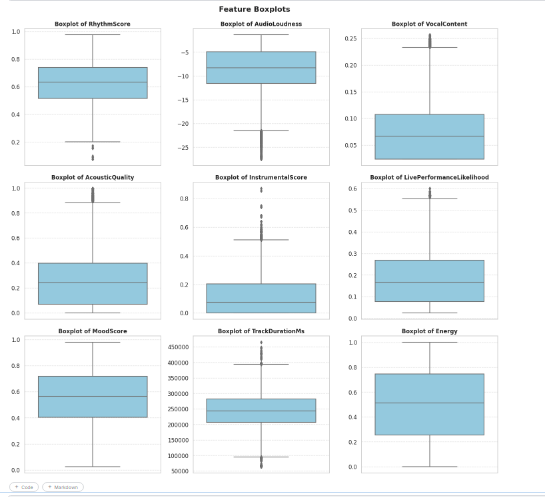

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns, excluding 'id' if present
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [c for c in numerical_cols if c.lower() != "id"]

# Define color palette
palette = sns.color_palette("husl", len(numerical_cols))

# Grid layout: e.g., 4 columns
ncols = 4
nrows = -(-len(numerical_cols) // ncols)  # ceiling division

plt.figure(figsize=(5*ncols, 4*nrows))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(y=train[col], color=palette[i-1], showfliers=True, whis=1.5)
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Boxplots of Numerical Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
num_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Columns to exclude

exclude_cols = ["id"]
num_features = [col for col in num_features if col not in exclude_cols]

# ==================================
# 5. Enhanced Correlation Analysis
# ==================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- You already have this from the previous step ---
# Assuming 'num_features' is your list of numeric columns
# ---------------------------------------------------

# 1. Calculate the correlation matrix once
corr_matrix = train[num_features].corr()

# 2. Create a mask to hide the redundant upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3. Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# 4. **Expert Tip**: Choose a better diverging colormap and center it
# 'vlag' is a great blue-white-red palette. 'icefire' is another good one.
# Centering at 0 ensures that 0 correlation is neutral (white).
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap="vlag", # A better color palette for correlations
            vmin=-1, vmax=1, # Lock the color scale
            center=0,
            linewidths=.5, # Add lines between cells
            cbar_kws={"shrink": .8}) # Shrink the color bar a bit

plt.title("Correlation Heatmap of Numeric Features", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# ====================================================
# 6. Correlation with Target Variable (Visualized)
# ====================================================

# Assuming 'target_col' is the name of your target variable string
target_col = 'BeatsPerMinute' # Replace with your actual target name

# We can reuse the corr_matrix from before
if 'corr_matrix' not in locals():
    corr_matrix = train[num_features].corr()

# Get correlations with the target, drop the target's self-correlation, and sort
target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="vlag", orient='h')

plt.title(f"Feature Correlation with {target_col}", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# You can still print the sorted values for exact numbers
print(f"\n--- Correlation with {target_col} ---")
print(target_corr)

### 👉 Observation: Correlation with BeatsPerMinute

The correlation analysis reveals an extremely important characteristic of this dataset: there is no meaningful linear relationship between any of the individual audio features and the target variable, BeatsPerMinute.

### Key Takeaways:

Extremely Weak Correlations: All correlation coefficients are exceptionally close to zero. The strongest positive correlation is with MoodScore at a negligible +0.007, and the strongest negative correlation is with Energy at an equally insignificant -0.004. In practical terms, these values indicate a complete absence of a linear trend.

### Implications for Modeling:

Linear Models Will Fail: Standard linear models (like Linear Regression, Ridge, Lasso) will perform very poorly on this task. These models rely on finding a linear relationship between the features and the target, which does not exist here.

Non-Linear Relationships Are Key:The lack of linear correlation does not mean there is no relationship at all. The connection between these features and BPM is likely complex, non-linear, and driven by interactions between features.

In [ ]:
# ==========================================================
# 7. FAST Targeted Pairplot via Random Sampling
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define your features and target ---
num_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Columns to exclude

exclude_cols = ["id"]
num_features = [col for col in num_features if col not in exclude_cols]
target_col = 'BeatsPerMinute'
predictor_features = [col for col in num_features if col != target_col]
# ----------------------------------------

# **THE KEY IMPROVEMENT: Create a smaller, random sample for plotting**
n_samples = 3000 # Start with 1k, increase if needed
if len(train) > n_samples:
    plot_df = train.sample(n=n_samples, random_state=42)
else:
    plot_df = train

print(f"Generating targeted pairplot on a sample of {len(plot_df)} data points for speed...")

# Now, run the EXACT SAME plotting code, but on the smaller 'plot_df'
g = sns.pairplot(
    plot_df, # Use the sample, not the full 'train' dataframe
    x_vars=predictor_features,
    y_vars=[target_col],
    kind='scatter',
    height=4,
    aspect=1.2,
    plot_kws={'alpha': 0.4, 's': 20, 'edgecolor': None} # Can use slightly less alpha
)

g.fig.suptitle(f"Relationships Between Features and {target_col} (on Sampled Data)", y=1.02, fontsize=16, weight='bold')
plt.show()

### 👉 Observation: 

This visualization powerfully confirms the findings from our numerical correlation analysis. The key takeaway is the complete absence of a discernible relationship between  Features and BeatsPerMinute.

### Key Takeaways:

No Pattern or Trend: The data points form a dense, rectangular "cloud" with no discernible shape. There is no upward (positive) or downward (negative) slope. Furthermore, there is no simple non-linear pattern (like a U-shape or curve) present.


